## Import Libraries

In [8]:
!pip install seaborn  

In [9]:
!pip install torch 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Add parent directory to path to import model
sys.path.insert(0, os.path.abspath('../..'))
from src.models.cnn import SeismicCNN, CompactSeismicCNN

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set up plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("\n✓ Libraries imported successfully!")

Using device: cpu

✓ Libraries imported successfully!


## Load Labeled Data

Load the windowed seismograms and labels created by the multi-class labeling notebook.

In [11]:
# Find the most recent labeled dataset
data_dir = Path("../02_labeling/labeled_data")

if not data_dir.exists():
    raise FileNotFoundError(f"Data directory '{data_dir}' not found. Run ../02_labeling/multi_class_labeling.ipynb first.")

# Find most recent files
waveform_files = sorted(data_dir.glob("windowed_waveforms_*.npy"))
label_files = sorted(data_dir.glob("labels_*.npy"))
metadata_files = sorted(data_dir.glob("metadata_*.csv"))

if not waveform_files or not label_files:
    raise FileNotFoundError("No labeled data found. Run multi_class_labeling.ipynb first.")

# Use most recent files
waveforms_file = waveform_files[-1]
labels_file = label_files[-1]
metadata_file = metadata_files[-1] if metadata_files else None

print(f"Loading data from:")
print(f"  Waveforms: {waveforms_file.name}")
print(f"  Labels: {labels_file.name}")
if metadata_file:
    print(f"  Metadata: {metadata_file.name}")

# Load data
X = np.load(waveforms_file)  # Shape: (n_samples, window_length)
y = np.load(labels_file)     # Shape: (n_samples,)

if metadata_file:
    metadata = pd.read_csv(metadata_file)
else:
    metadata = None

print(f"\n✓ Data loaded successfully!")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")

# Print class distribution
class_names = ['Noise', 'Traffic', 'Earthquake']
unique, counts = np.unique(y, return_counts=True)
print(f"\nClass distribution:")
for label, count in zip(unique, counts):
    print(f"  {class_names[int(label)]} (class {int(label)}): {count} samples ({count/len(y)*100:.1f}%)")

Loading data from:
  Waveforms: windowed_waveforms_20251210_170458.npy
  Labels: labels_20251210_170458.npy
  Metadata: metadata_20251210_170458.csv

✓ Data loaded successfully!
  X shape: (719, 500)
  y shape: (719,)

Class distribution:
  Noise (class 0): 300 samples (41.7%)
  Traffic (class 1): 18 samples (2.5%)
  Earthquake (class 2): 401 samples (55.8%)

✓ Data loaded successfully!
  X shape: (719, 500)
  y shape: (719,)

Class distribution:
  Noise (class 0): 300 samples (41.7%)
  Traffic (class 1): 18 samples (2.5%)
  Earthquake (class 2): 401 samples (55.8%)


## Prepare Data for Training

Split data into train/validation/test sets and create PyTorch DataLoaders.

In [12]:
# Add channel dimension for CNN: (n_samples, window_length) -> (n_samples, 1, window_length)
X = X[:, np.newaxis, :]  # Add channel dimension

print(f"Reshaped X: {X.shape}")

# Split data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nData split:")
print(f"  Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Val:   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Print class distribution per split
for split_name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    print(f"\n{split_name} class distribution:")
    unique, counts = np.unique(y_split, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"  {class_names[int(label)]}: {count} ({count/len(y_split)*100:.1f}%)")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n✓ DataLoaders created with batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Reshaped X: (719, 1, 500)

Data split:
  Train: 503 samples (70.0%)
  Val:   108 samples (15.0%)
  Test:  108 samples (15.0%)

Train class distribution:
  Noise: 210 (41.7%)
  Traffic: 13 (2.6%)
  Earthquake: 280 (55.7%)

Val class distribution:
  Noise: 45 (41.7%)
  Traffic: 2 (1.9%)
  Earthquake: 61 (56.5%)

Test class distribution:
  Noise: 45 (41.7%)
  Traffic: 3 (2.8%)
  Earthquake: 60 (55.6%)

✓ DataLoaders created with batch size: 32
  Train batches: 16
  Val batches: 4
  Test batches: 4


## Configuration

Configure training parameters and models to train.


In [13]:
# Model configuration
num_classes = 3
input_channels = 1  # Single channel (vertical component)
input_length = X_train.shape[2]  # Window length in samples

print(f"Model configuration:")
print(f"  Input channels: {input_channels}")
print(f"  Input length: {input_length} samples")
print(f"  Number of classes: {num_classes}")

# Training hyperparameters
num_epochs = 50
learning_rate = 0.001
weight_decay = 1e-4
batch_size = 32

# Models to train
models_to_train = ['compact', 'standard']  # Train both models

print(f"\nTraining configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {weight_decay}")
print(f"  Batch size: {batch_size}")
print(f"\n✓ Will train {len(models_to_train)} models: {', '.join(models_to_train)}")


Model configuration:
  Input channels: 1
  Input length: 500 samples
  Number of classes: 3

Training configuration:
  Epochs: 50
  Learning rate: 0.001
  Weight decay: 0.0001
  Batch size: 32

✓ Will train 2 models: compact, standard


## Training Loop for Both Models

Train both compact and standard models, saving each one separately.


In [14]:
import time

# Loss function (with class weights for imbalanced data)
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_weights)  # Normalize
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print(f"Class weights for loss function:")
for i, (name, weight) in enumerate(zip(class_names, class_weights)):
    print(f"  {name}: {weight:.3f}")


def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss / total, 100 * correct / total


def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss / total, 100 * correct / total


def train_model(model, model_type, train_loader, val_loader, criterion, num_epochs, learning_rate, weight_decay, device):
    """Train a model and return history and best state."""
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_loss = float('inf')
    best_model_state = None
    
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n{'='*70}")
    print(f"Training {model_type.upper()} Model ({n_params:,} parameters)")
    print(f"{'='*70}")
    print(f"{'Epoch':<6} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12} {'Time':<8}")
    print("-" * 70)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
        epoch_time = time.time() - start_time
        print(f"{epoch+1:<6} {train_loss:<12.4f} {train_acc:<12.2f} {val_loss:<12.4f} {val_acc:<12.2f} {epoch_time:<8.2f}s")
    
    print(f"\n✓ {model_type.capitalize()} model training complete!")
    print(f"  Best validation loss: {best_val_loss:.4f}")
    print(f"  Final train accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"  Final val accuracy: {history['val_acc'][-1]:.2f}%")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return history, best_val_loss, n_params


# Store results for all models
all_results = {}

# Create models directory
models_dir = Path("../../models")
models_dir.mkdir(exist_ok=True)

# Train each model
for model_type in models_to_train:
    print(f"\n{'#'*70}")
    print(f"# TRAINING {model_type.upper()} MODEL")
    print(f"{'#'*70}\n")
    
    # Initialize model
    if model_type == 'standard':
        model = SeismicCNN(
            num_classes=num_classes,
            input_channels=input_channels,
            input_length=input_length,
            dropout_rate=0.3
        )
    else:
        model = CompactSeismicCNN(
            num_classes=num_classes,
            input_channels=input_channels,
            input_length=input_length
        )
    
    model = model.to(device)
    
    # Create loss function for this model
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    # Train the model
    history, best_val_loss, n_params = train_model(
        model, model_type, train_loader, val_loader, criterion,
        num_epochs, learning_rate, weight_decay, device
    )
    
    # Evaluate on test set
    model.eval()
    y_true = []
    y_pred = []
    y_proba = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_proba.extend(probabilities.cpu().numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)
    
    test_accuracy = accuracy_score(y_true, y_pred)
    
    print(f"\n{model_type.capitalize()} Model Test Results:")
    print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))
    
    # Save model
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f"seismic_cnn_{model_type}_{timestamp}.pth"
    model_path = models_dir / model_filename
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_type': model_type,
        'num_classes': num_classes,
        'input_channels': input_channels,
        'input_length': input_length,
        'class_names': class_names,
        'test_accuracy': test_accuracy,
        'history': history,
        'training_config': {
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay
        }
    }, model_path)
    
    print(f"\n✓ Model saved to: {model_path}")
    
    # Store results
    all_results[model_type] = {
        'model': model,
        'history': history,
        'test_accuracy': test_accuracy,
        'n_params': n_params,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'model_path': model_path
    }
    
    # Small delay between models
    time.sleep(1)

print(f"\n{'='*70}")
print(f"ALL MODELS TRAINED SUCCESSFULLY!")
print(f"{'='*70}")


Class weights for loss function:
  Noise: 0.168
  Traffic: 2.707
  Earthquake: 0.126

######################################################################
# TRAINING COMPACT MODEL
######################################################################


Training COMPACT Model (9,347 parameters)
Epoch  Train Loss   Train Acc    Val Loss     Val Acc      Time    
----------------------------------------------------------------------


1      0.9112       45.92        0.9591       61.11        0.38    s
2      0.8051       76.74        0.8003       71.30        0.38    s
2      0.8051       76.74        0.8003       71.30        0.38    s
3      0.7798       70.58        0.7562       69.44        0.38    s
3      0.7798       70.58        0.7562       69.44        0.38    s
4      0.7124       74.16        0.7014       75.93        0.39    s
4      0.7124       74.16        0.7014       75.93        0.39    s
5      0.6893       75.15        0.6798       76.85        0.39    s
5      0.6893       75.15        0.6798       76.85        0.39    s
6      0.6429       77.14        0.6503       81.48        0.38    s
6      0.6429       77.14        0.6503       81.48        0.38    s
7      0.6085       78.13        0.6391       81.48        0.38    s
7      0.6085       78.13        0.6391       81.48        0.38    s
8      0.5914       76.54        0.6468       77.78        0.41    s
8      0.5914       76.54        0

## Compare Model Performance

Visualize training history and compare both models side-by-side.


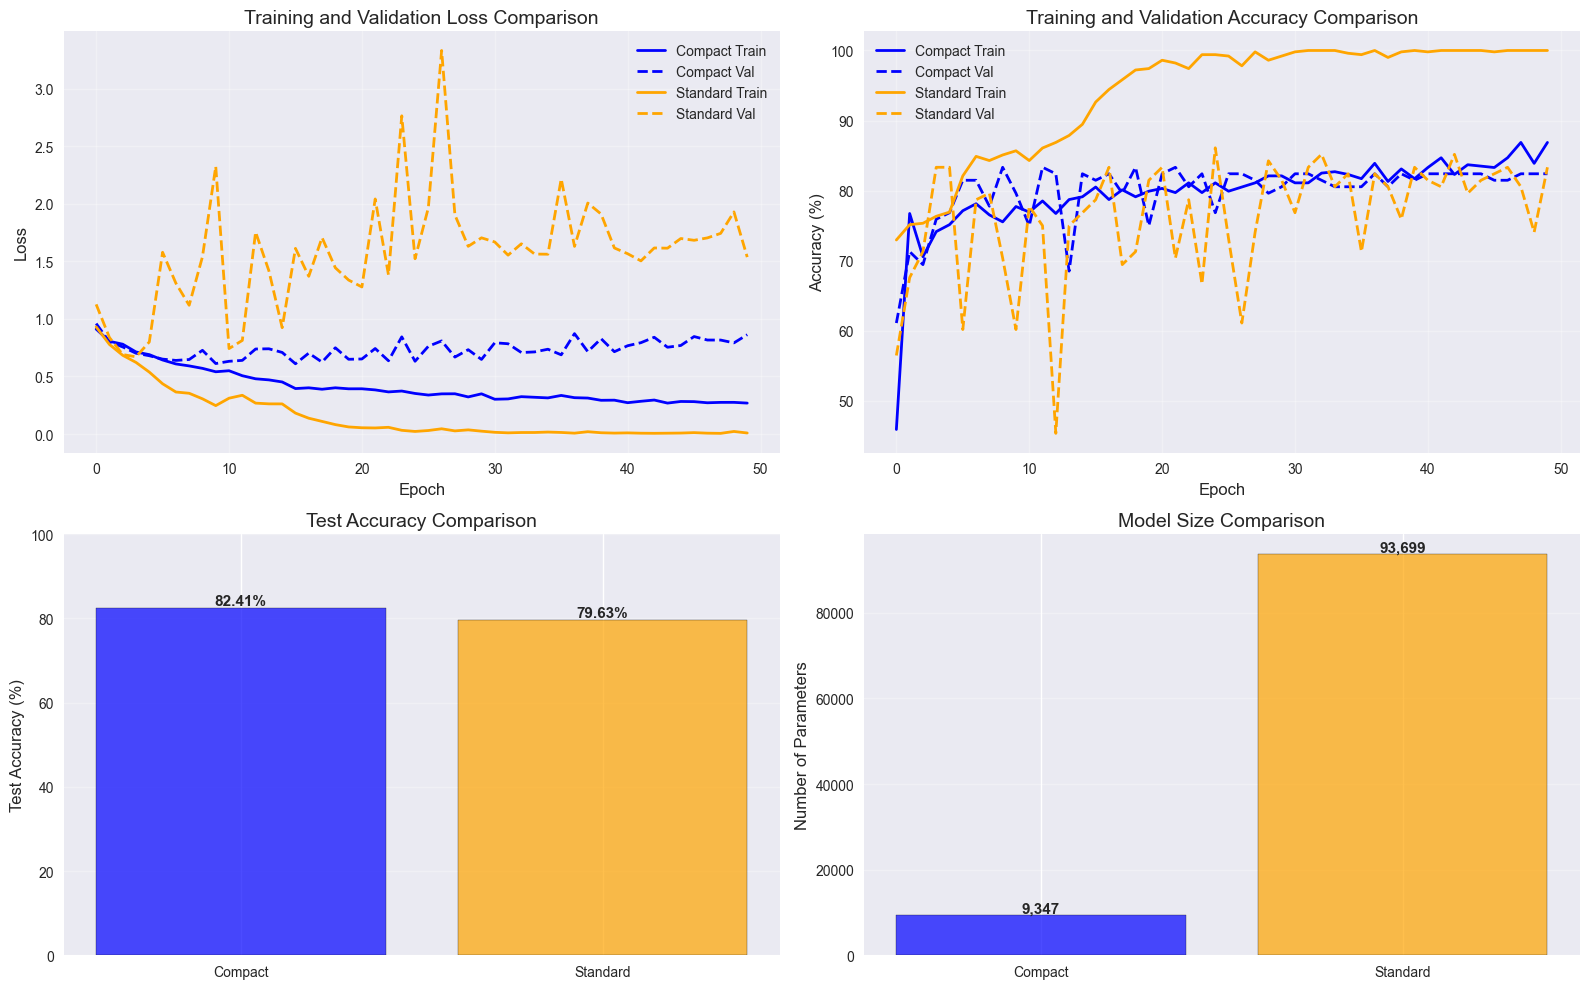


MODEL COMPARISON SUMMARY
Model           Parameters      Test Accuracy   Saved To                      
----------------------------------------------------------------------
Compact         9,347           82.41           seismic_cnn_compact_20251210_200121.pth
Standard        93,699          79.63           seismic_cnn_standard_20251210_200210.pth


In [15]:
# Plot training curves for both models
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

colors = {'compact': 'blue', 'standard': 'orange'}
line_styles = {'train': '-', 'val': '--'}

# Loss comparison
ax = axes[0, 0]
for model_type in models_to_train:
    history = all_results[model_type]['history']
    ax.plot(history['train_loss'], label=f'{model_type.capitalize()} Train', 
            color=colors[model_type], linestyle=line_styles['train'], linewidth=2)
    ax.plot(history['val_loss'], label=f'{model_type.capitalize()} Val', 
            color=colors[model_type], linestyle=line_styles['val'], linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training and Validation Loss Comparison', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Accuracy comparison
ax = axes[0, 1]
for model_type in models_to_train:
    history = all_results[model_type]['history']
    ax.plot(history['train_acc'], label=f'{model_type.capitalize()} Train', 
            color=colors[model_type], linestyle=line_styles['train'], linewidth=2)
    ax.plot(history['val_acc'], label=f'{model_type.capitalize()} Val', 
            color=colors[model_type], linestyle=line_styles['val'], linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Training and Validation Accuracy Comparison', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Model comparison bar chart - Test Accuracy
ax = axes[1, 0]
model_names = [m.capitalize() for m in models_to_train]
test_accs = [all_results[m]['test_accuracy'] * 100 for m in models_to_train]
params = [all_results[m]['n_params'] for m in models_to_train]

bars = ax.bar(model_names, test_accs, color=[colors[m] for m in models_to_train], alpha=0.7, edgecolor='black')
ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Test Accuracy Comparison', fontsize=14)
ax.set_ylim([0, 100])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, test_accs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Model comparison - Parameters
ax = axes[1, 1]
bars = ax.bar(model_names, params, color=[colors[m] for m in models_to_train], alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Parameters', fontsize=12)
ax.set_title('Model Size Comparison', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, param in zip(bars, params):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{param:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Print comparison summary
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(f"{'Model':<15} {'Parameters':<15} {'Test Accuracy':<15} {'Saved To':<30}")
print("-"*70)
for model_type in models_to_train:
    result = all_results[model_type]
    print(f"{model_type.capitalize():<15} {result['n_params']:<15,} {result['test_accuracy']*100:<15.2f} {result['model_path'].name:<30}")
print("="*70)


## Confusion Matrices for Both Models

Compare confusion matrices to see how each model performs on different classes.


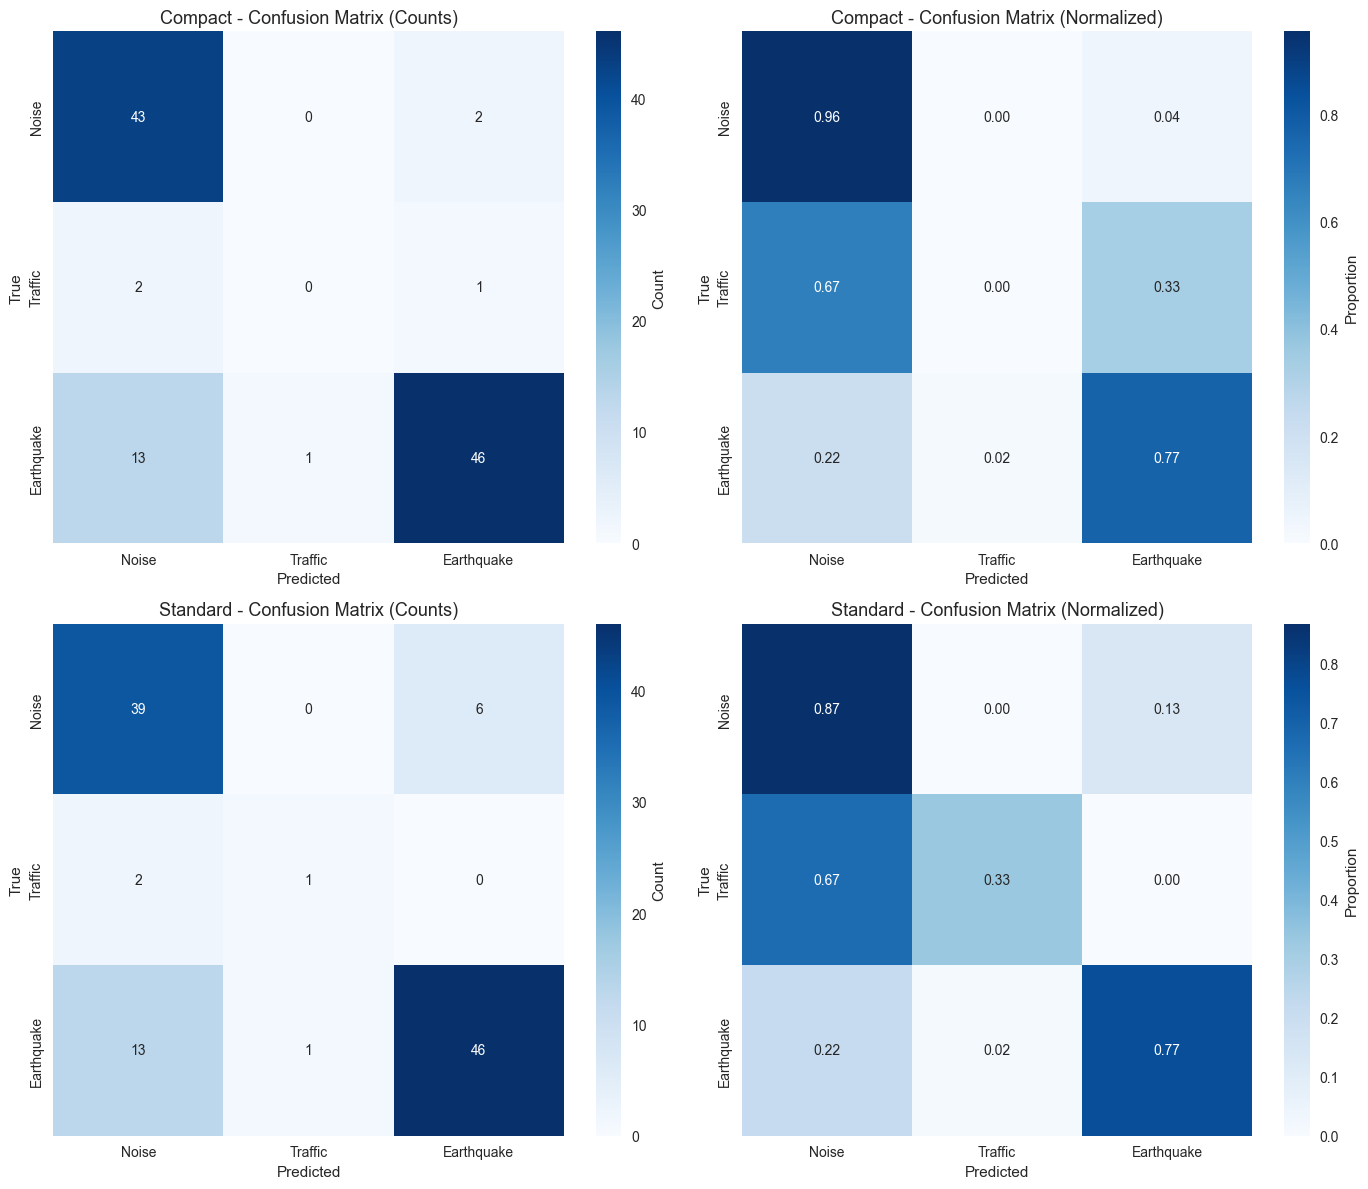

✓ Confusion matrices plotted for both models


In [16]:
# Plot confusion matrices for both models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, model_type in enumerate(models_to_train):
    y_true = all_results[model_type]['y_true']
    y_pred = all_results[model_type]['y_pred']
    
    # Compute confusion matrices
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Raw counts
    ax = axes[idx, 0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, 
                yticklabels=class_names, ax=ax, cbar_kws={'label': 'Count'})
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('True', fontsize=11)
    ax.set_title(f'{model_type.capitalize()} - Confusion Matrix (Counts)', fontsize=13)
    
    # Normalized
    ax = axes[idx, 1]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names,
                yticklabels=class_names, ax=ax, cbar_kws={'label': 'Proportion'})
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('True', fontsize=11)
    ax.set_title(f'{model_type.capitalize()} - Confusion Matrix (Normalized)', fontsize=13)

plt.tight_layout()
plt.show()

print("✓ Confusion matrices plotted for both models")


## Example Predictions

Visualize predictions from the compact model on test examples.


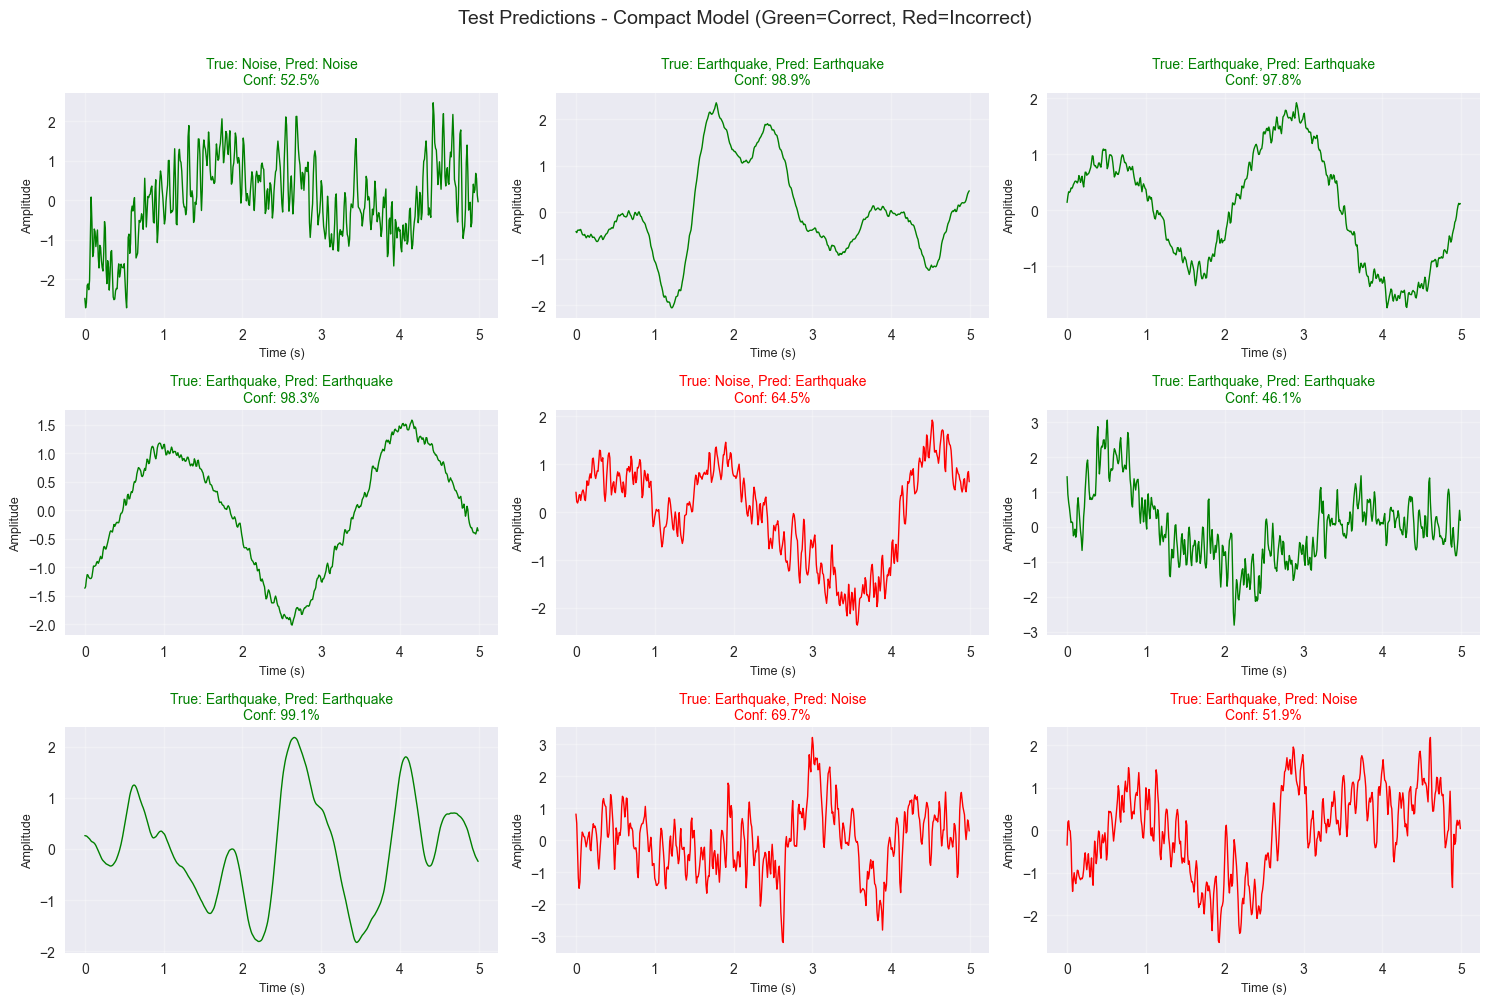

✓ Example predictions visualized


In [17]:
# Use compact model for visualization
model_type = 'compact'
y_pred = all_results[model_type]['y_pred']
y_proba = all_results[model_type]['y_proba']

# Select random examples from test set
n_examples = 9
random_indices = np.random.choice(len(X_test), n_examples, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    ax = axes[i]
    
    # Get waveform
    waveform = X_test[idx, 0, :]  # Remove channel dimension
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    proba = y_proba[idx]
    
    # Plot waveform
    time_axis = np.arange(len(waveform)) / 100.0  # Assuming 100 Hz
    color = 'green' if true_label == pred_label else 'red'
    ax.plot(time_axis, waveform, color=color, linewidth=1)
    
    # Title with prediction info
    title = f"True: {class_names[true_label]}, Pred: {class_names[pred_label]}\n"
    title += f"Conf: {proba[pred_label]*100:.1f}%"
    ax.set_title(title, fontsize=10, color=color)
    ax.set_xlabel('Time (s)', fontsize=9)
    ax.set_ylabel('Amplitude', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Test Predictions - {model_type.capitalize()} Model (Green=Correct, Red=Incorrect)', 
             fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("✓ Example predictions visualized")


## Training Summary

Both models have been saved. Review the final summary.


In [18]:
# Print final summary
print("="*70)
print("TRAINING COMPLETE - FINAL SUMMARY")
print("="*70)

for model_type in models_to_train:
    result = all_results[model_type]
    print(f"\n{model_type.upper()} MODEL:")
    print(f"  Parameters: {result['n_params']:,}")
    print(f"  Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"  Saved to: {result['model_path']}")
    
    # Save training summary
    timestamp = result['model_path'].stem.split('_')[-1]
    summary_file = models_dir / f"training_summary_{model_type}_{timestamp}.txt"
    
    with open(summary_file, 'w') as f:
        f.write(f"Seismic CNN Training Summary - {model_type.upper()} Model\n")
        f.write("="*60 + "\n\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("Model Configuration:\n")
        f.write(f"  Type: {model_type}\n")
        f.write(f"  Parameters: {result['n_params']:,}\n")
        f.write(f"  Input shape: (batch, {input_channels}, {input_length})\n")
        f.write(f"  Number of classes: {num_classes}\n\n")
        
        f.write("Training Configuration:\n")
        f.write(f"  Epochs: {num_epochs}\n")
        f.write(f"  Batch size: {batch_size}\n")
        f.write(f"  Learning rate: {learning_rate}\n")
        f.write(f"  Weight decay: {weight_decay}\n\n")
        
        f.write("Dataset Split:\n")
        f.write(f"  Train: {len(X_train)} samples\n")
        f.write(f"  Validation: {len(X_val)} samples\n")
        f.write(f"  Test: {len(X_test)} samples\n\n")
        
        history = result['history']
        f.write("Results:\n")
        f.write(f"  Best validation loss: {min(history['val_loss']):.4f}\n")
        f.write(f"  Final train accuracy: {history['train_acc'][-1]:.2f}%\n")
        f.write(f"  Final val accuracy: {history['val_acc'][-1]:.2f}%\n")
        f.write(f"  Test accuracy: {result['test_accuracy']*100:.2f}%\n\n")
        
        f.write("Classification Report:\n")
        f.write(classification_report(result['y_true'], result['y_pred'], 
                                     target_names=class_names, digits=3))
    
    print(f"  Summary saved to: {summary_file}")

print("\n" + "="*70)
print("Both models trained and saved successfully!")
print(f"Models directory: {models_dir}")
print("="*70)


TRAINING COMPLETE - FINAL SUMMARY

COMPACT MODEL:
  Parameters: 9,347
  Test Accuracy: 82.41%
  Saved to: ../../models/seismic_cnn_compact_20251210_200121.pth
  Summary saved to: ../../models/training_summary_compact_200121.txt

STANDARD MODEL:
  Parameters: 93,699
  Test Accuracy: 79.63%
  Saved to: ../../models/seismic_cnn_standard_20251210_200210.pth
  Summary saved to: ../../models/training_summary_standard_200210.txt

Both models trained and saved successfully!
Models directory: ../../models
